# スタッキング

In [49]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

In [0]:
data = pd.read_csv("/content/drive/My Drive/Colab Notebooks/titanic/train.csv")
test = pd.read_csv("/content/drive/My Drive/Colab Notebooks/titanic/test.csv")

# 前処理

- Ageの補完とSexを3分割は前回と同じ

In [0]:
middle = data["Name"].str.split(", ", expand=True)
middle = middle[1].str.split(".", expand=True)
data["Middle"] = middle[0]
data.loc[(data["Middle"] != "Mr") 
         & (data["Middle"] != "Mrs") 
         & (data["Middle"] != "Miss") 
         & (data["Middle"] != "Master"), "Middle"] = "Other"
data.loc[(data["Middle"] == "Other") 
         & (data["Age"] < data.loc[data["Middle"] == "Other", "Age"].dropna().median()), "Middle"] = "Other_pre"
data.loc[(data["Middle"] == "Other"), "Middle"] = "Other_post"
data.loc[data["Age"].isnull(), ["Middle", "Age"]]
for middle in ["Mr", "Mrs", "Miss", "Master", "Other_pre", "Other_post"]:
    data.loc[(data["Age"].isnull()) & (data["Middle"] == middle), "Age"] = data.loc[
        data["Middle"] == middle, "Age"].dropna().median()
data.loc[(data["Middle"] == "Mr") & (data["Sex"] == "male"), "Sex"] = "Mr"
data.loc[(data["Middle"] != "Mr") & (data["Sex"] == "male"), "Sex"] = "notMr"

### テストデータに対しても同じ操作を行う(補完に関しては前回と同じ)

In [0]:
middle = test["Name"].str.split(", ", expand=True)
middle = middle[1].str.split(".", expand=True)
test["Middle"] = middle[0]
test.loc[(test["Middle"] != "Mr") 
         & (test["Middle"] != "Mrs") 
         & (test["Middle"] != "Miss") 
         & (test["Middle"] != "Master"), "Middle"] = "Other"
test.loc[(test["Middle"] == "Other") 
         & (test["Age"] < test.loc[test["Middle"] == "Other", "Age"].dropna().median()), "Middle"] = "Other_pre"
test.loc[(test["Middle"] == "Other"), "Middle"] = "Other_post"
test.loc[test["Age"].isnull(), ["Middle", "Age"]]
for middle in ["Mr", "Mrs", "Miss", "Master", "Other_pre", "Other_post"]:
    test.loc[(test["Age"].isnull()) & (test["Middle"] == middle), "Age"] = test.loc[
        test["Middle"] == middle, "Age"].dropna().median()
test["Fare"] = test["Fare"].fillna(test.loc[test["Middle"] == "Mr", "Fare"].dropna().median())
test.loc[(test["Middle"] == "Mr") & (test["Sex"] == "male"), "Sex"] = "Mr"
test.loc[(test["Middle"] != "Mr") & (test["Sex"] == "male"), "Sex"] = "notMr"

### 特徴量FamilySizeの導入

In [0]:
data["FamilySize"] = data["SibSp"] + data["Parch"] + 1
test["FamilySize"] = test["SibSp"] + test["Parch"] + 1

### Cabin

In [0]:
data["Cabin"] = data["Cabin"].fillna(0)
data.loc[data["Cabin"] != 0, "Cabin"] = 1
test["Cabin"] = test["Cabin"].fillna(0)
test.loc[test["Cabin"] != 0, "Cabin"] = 1

In [56]:
data.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Middle,FamilySize
0,1,0,3,"Braund, Mr. Owen Harris",Mr,22.0,1,0,A/5 21171,7.2500,0,S,Mr,2
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,1,C,Mrs,2
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,0,S,Miss,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,1,S,Mrs,2
4,5,0,3,"Allen, Mr. William Henry",Mr,35.0,0,0,373450,8.0500,0,S,Mr,1
5,6,0,3,"Moran, Mr. James",Mr,30.0,0,0,330877,8.4583,0,Q,Mr,1
6,7,0,1,"McCarthy, Mr. Timothy J",Mr,54.0,0,0,17463,51.8625,1,S,Mr,1
7,8,0,3,"Palsson, Master. Gosta Leonard",notMr,2.0,3,1,349909,21.0750,0,S,Master,5
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,0,S,Mrs,3
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,0,C,Mrs,2


### Embarked

In [0]:
data["Embarked"] = data["Embarked"].fillna("S")

# X, yに分ける

In [58]:
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Middle,FamilySize
0,1,0,3,"Braund, Mr. Owen Harris",Mr,22.0,1,0,A/5 21171,7.2500,0,S,Mr,2
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,1,C,Mrs,2
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,0,S,Miss,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,1,S,Mrs,2
4,5,0,3,"Allen, Mr. William Henry",Mr,35.0,0,0,373450,8.0500,0,S,Mr,1


In [0]:
X = data.drop(["PassengerId", "Survived", "Name", "SibSp", "Parch", "Ticket", "Middle"], axis=1)
y = data["Survived"]
X_test = test.drop(["PassengerId", "Name", "SibSp", "Parch", "Ticket", "Middle"], axis=1)

In [60]:
X.head()

,Pclass,Sex,Age,Fare,Cabin,Embarked,FamilySize
0,3,Mr,22.0,7.2500,0,S,2
1,1,female,38.0,71.2833,1,C,2
2,3,female,26.0,7.9250,0,S,1
3,1,female,35.0,53.1000,1,S,2
4,3,Mr,35.0,8.0500,0,S,1


# ワンホットエンコーディング

- Pclass, Sex -> ワンホットエンコーディング

In [0]:
X = pd.get_dummies(X, columns=["Pclass"])
X = pd.get_dummies(X, columns=["Sex"])
X = pd.get_dummies(X, columns=["Embarked"])
X_test = pd.get_dummies(X_test, columns=["Pclass"])
X_test = pd.get_dummies(X_test, columns=["Sex"])
X_test = pd.get_dummies(X_test, columns=["Embarked"])

In [77]:
X.head()

,Age,Fare,Cabin,FamilySize,Pclass_1,Pclass_2,Pclass_3,Sex_Mr,Sex_female,Sex_notMr,Embarked_C,Embarked_Q,Embarked_S
0,22.0,7.2500,0,2,0,0,1,1,0,0,0,0,1
1,38.0,71.2833,1,2,1,0,0,0,1,0,1,0,0
2,26.0,7.9250,0,1,0,0,1,0,1,0,0,0,1
3,35.0,53.1000,1,2,1,0,0,0,1,0,0,0,1
4,35.0,8.0500,0,1,0,0,1,1,0,0,0,0,1


# Stacking

In [0]:
from sklearn.model_selection import train_test_split

In [0]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# Grid Search

In [78]:
params = {
    "n_estimators":[100, 200, 300],
    "max_features": [3, 5, 7, 10],
    "min_samples_split": [2, 10, 20]
}
gscv = GridSearchCV(RandomForestClassifier(random_state=0), params, cv=3)
gscv.fit(X, y)

print('Best score: {}'.format(gscv.best_score_))
print('Best parameters: {}'.format(gscv.best_params_))

Best score: 0.8406285072951739
Best parameters: {'max_features': 10, 'min_samples_split': 10, 'n_estimators': 300}


In [81]:
params = {
    "C":[0.001, 0.01, 0.1, 1, 10, 100]
}
gscv = GridSearchCV(LogisticRegression(solver='lbfgs', multi_class='auto', max_iter=10000), params, cv=3)
gscv.fit(X, y)

print('Best score: {}'.format(gscv.best_score_))
print('Best parameters: {}'.format(gscv.best_params_))

Best score: 0.8159371492704826
Best parameters: {'C': 0.1}


In [82]:
params = {
    "C":[0.001, 0.01, 0.1, 1, 10, 100],
    "gamma":[0.001, 0.01, 0.1, 1, 10, 100]
}
gscv = GridSearchCV(SVC(), params, cv=3)
gscv.fit(X, y)

print('Best score: {}'.format(gscv.best_score_))
print('Best parameters: {}'.format(gscv.best_params_))

Best score: 0.7946127946127947
Best parameters: {'C': 100, 'gamma': 0.001}


In [83]:
params = {
    "max_depth": [2,4,6,8,10],
    "max_features": ['log2', 'sqrt','auto'],
    "min_samples_split": [3, 5, 7, 9],
    "min_samples_leaf": [1,5,8],
    "criterion": ["gini", "entropy"]
}
gscv = GridSearchCV(DecisionTreeClassifier(random_state=0), params, cv=3)
gscv.fit(X, y)

print('Best score: {}'.format(gscv.best_score_))
print('Best parameters: {}'.format(gscv.best_params_))

Best score: 0.8181818181818182
Best parameters: {'criterion': 'gini', 'max_depth': 8, 'max_features': 'log2', 'min_samples_leaf': 5, 'min_samples_split': 3}


In [85]:
params = {
    "gamma":[0.001, 0.01, 0.1, 1, 10, 100],
    "learning_rate":[0.001, 0.01, 0.1, 1, 10, 100],
    "max_depth":[2,4,6,8,10],
    "n_estimators":[50, 100, 200, 300]
}
gscv = GridSearchCV(XGBClassifier(random_state=0), params, cv=3)
gscv.fit(X, y)

print('Best score: {}'.format(gscv.best_score_))
print('Best parameters: {}'.format(gscv.best_params_))

Best score: 0.8417508417508418
Best parameters: {'gamma': 0.01, 'learning_rate': 0.01, 'max_depth': 8, 'n_estimators': 300}


In [87]:
params = {
    "learning_rate":[0.001, 0.01, 0.1, 1, 10, 100],
    "max_depth":[2,4,6,8,10],
    "n_estimators":[50, 100, 200, 300],
    "num_leaves":[10, 20, 30, 40, 50]
}
gscv = GridSearchCV(XGBClassifier(random_state=0), params, cv=3)
gscv.fit(X, y)

print('Best score: {}'.format(gscv.best_score_))
print('Best parameters: {}'.format(gscv.best_params_))

Best score: 0.8406285072951739
Best parameters: {'learning_rate': 0.01, 'max_depth': 8, 'n_estimators': 300, 'num_leaves': 10}


In [0]:
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=3)

- max_depthとn_estimatorsの値を細かく調整

In [0]:
clfs = [LogisticRegression(solver='lbfgs', multi_class='auto', max_iter=10000, C=0.1),
        SVC(probability=True, C=100, gamma=0.001),
        DecisionTreeClassifier(criterion="gini", max_depth=8, max_features="log2", min_samples_leaf=5, min_samples_split=3),
        RandomForestClassifier(max_depth=4, max_features=10, min_samples_split=10, n_estimators=30),
        XGBClassifier(gamma=0.01, learning_rate=0.01, max_depth=4, n_estimators=30),
        LGBMClassifier(learning_rate=0.01, max_depth=4, n_estimators=10, num_leaves=30)]

blend_train = np.zeros((X.shape[0], len(clfs)))
blend_test = np.zeros((X_test.shape[0], len(clfs)))

for j, clf in enumerate(clfs):         
  blend_test_j = np.zeros((X_test.shape[0], 3))
  for i, (train_index, test_index) in enumerate(skf.split(X, y)):
    # X1, y1でfittingを行い、X2のpredictを出す(ブレンドデータ)
    X1 = X.iloc[train_index]
    X2 = X.iloc[test_index]
    y1 = y.iloc[train_index]
    y2 = y.iloc[test_index]
    clf.fit(X1, y1)
    pred = clf.predict(X2)
    blend_train[test_index, j] = pred
    blend_test_j[:, i] = clf.predict(X_test)
  blend_test[:, j] = blend_test_j.mean(1)

In [127]:
params = {
    'C':[0.001, 0.01, 0.1, 1, 10, 100],
}
gscv = GridSearchCV(LogisticRegression(solver='lbfgs', multi_class='auto', max_iter=10000), params, cv=4)
gscv.fit(blend_train, y)

print('Best score: {}'.format(gscv.best_score_))
print('Best parameters: {}'.format(gscv.best_params_))

Best score: 0.8282828282828283
Best parameters: {'C': 1}


In [128]:
clf = LogisticRegression()
clf.fit(blend_train, y)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

# 提出用ファイルを作成

In [0]:
pred = clf.predict(blend_test)
submit = pd.DataFrame({"PassengerId":test["PassengerId"], "Survived":pred})
submit.to_csv("/content/drive/My Drive/Colab Notebooks/titanic/gender_submission.csv",index=False)

In [0]:
from google.colab import files
files.download("/content/drive/My Drive/Colab Notebooks/titanic/gender_submission.csv")

# 結果

# 重要度をみてみる

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


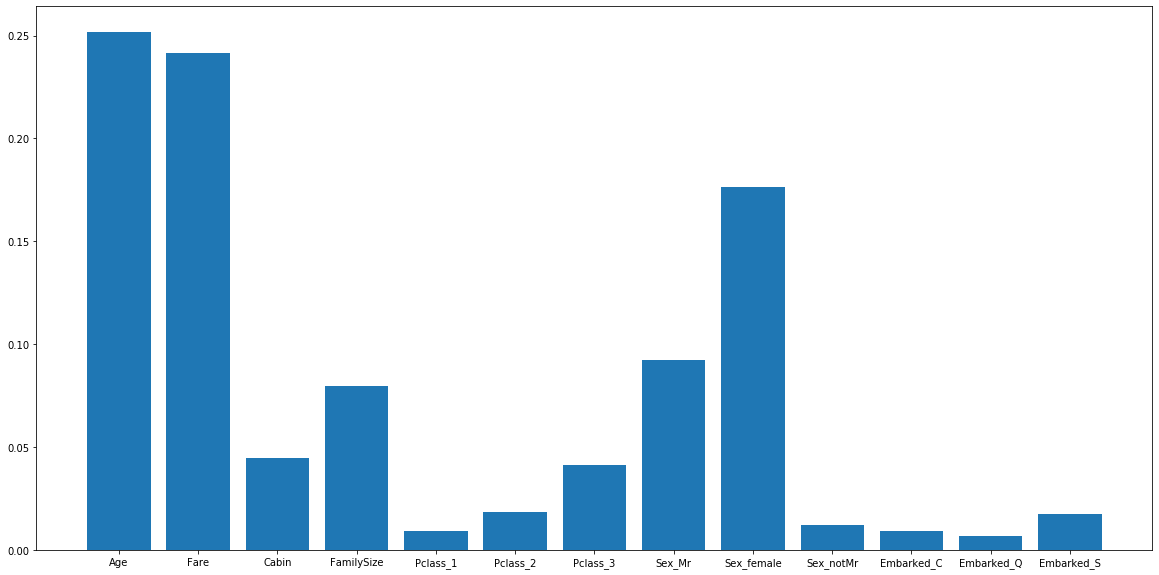

In [45]:
rf = RandomForestClassifier()
rf.fit(X, y)
feature = rf.feature_importances_
plt.figure(figsize=(20, 10))
plt.bar(range(len(feature)), feature, tick_label=X.columns)
plt.show()

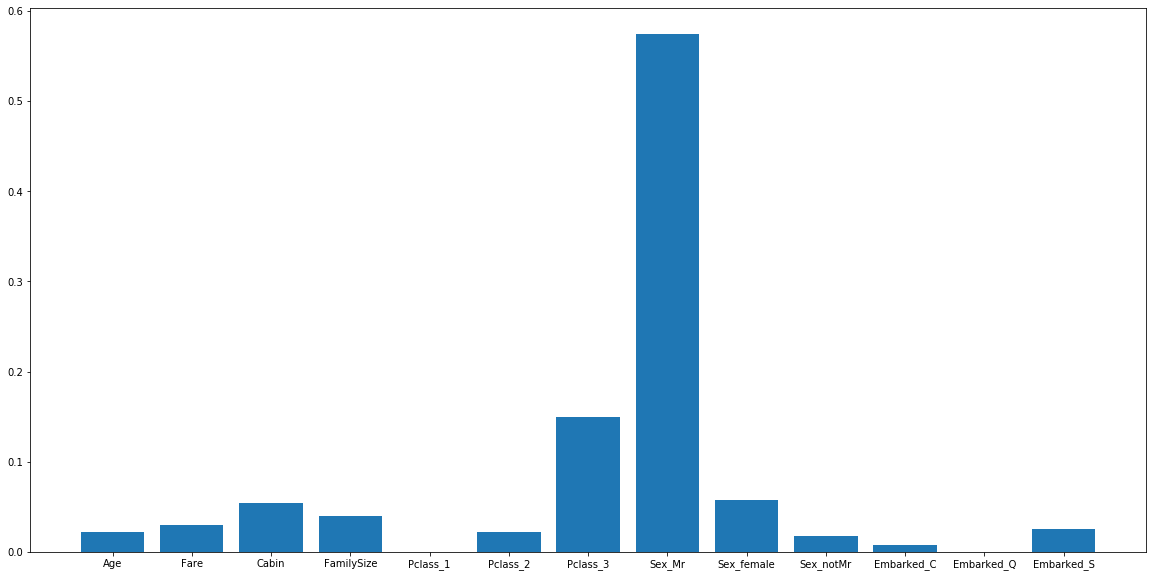

In [46]:
xgb = XGBClassifier()
xgb.fit(X, y)
feature = xgb.feature_importances_
plt.figure(figsize=(20, 10))
plt.bar(range(len(feature)), feature, tick_label=X.columns)
plt.show()

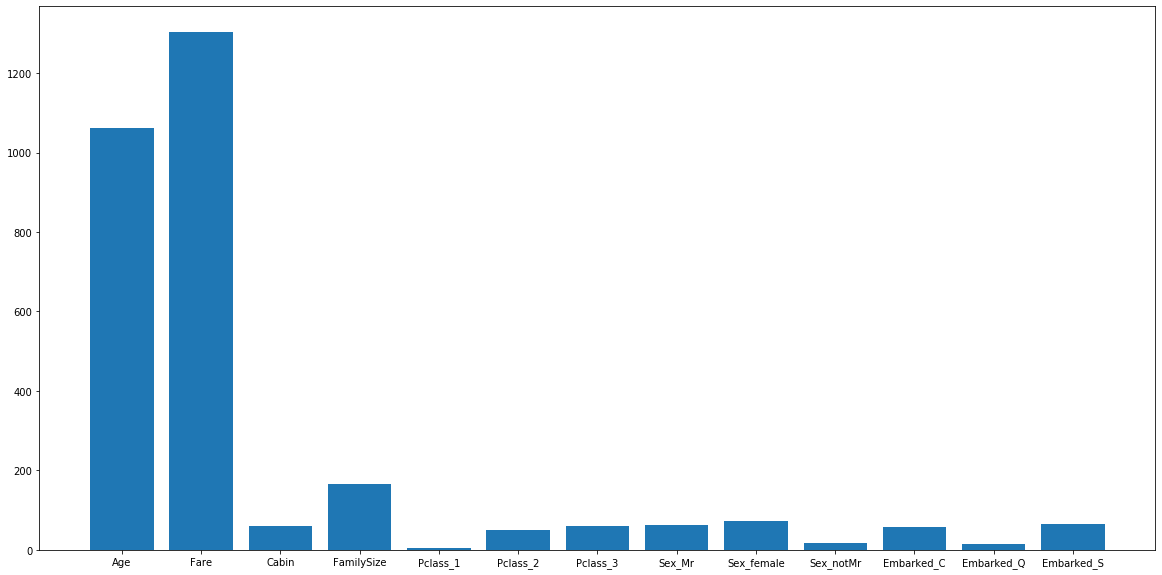

In [47]:
lgb = LGBMClassifier()
lgb.fit(X, y)
feature = lgb.feature_importances_
plt.figure(figsize=(20, 10))
plt.bar(range(len(feature)), feature, tick_label=X.columns)
plt.show()